In [44]:
%matplotlib inline
import deepdish as dd
import h5py
import numpy as np
from galaxy_analysis.analysis import Galaxy
from galaxy_analysis.plot.plot_styles import *
import matplotlib.pyplot as plt
from galaxy_analysis.utilities import utilities
from galaxy_analysis.utilities import convert_abundances

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import glob

import yt

import os


def plot_settings():
    fsize = 21
    rc('text',usetex=False)
    rc('font',size=fsize)
    return

plot_settings()


yr_s = 3.154E7

def is_alive(data, t):
    
    lifetime = data[('io','particle_model_lifetime')].convert_to_units('Myr')
    t0       = data['creation_time'].convert_to_units('Myr')
    alive    = np.array([True] * np.size(t0))
    
    not_born    = t <  t0
    dead        = t > (t0 + lifetime)
    alive[not_born] = False
    alive[dead]     = False
    
    return alive
    
    

In [45]:
def dlist_asarray(dict_list, key_list, as_list = False):
    
    res = [None]*len(dict_list)
    #print(len(dict_list))
    
    for i,d in enumerate(dict_list):
        res[i] = extract_nested_dict(d, key_list)
        
    if as_list:
        return res
    
    return np.array(res)
    
    
def extract_nested_dict(d, key_list):
    
    if isinstance(key_list, str):
        return d[key_list]
    elif len(key_list) == 1:
        return d[key_list[0]]
    
    return extract_nested_dict( d[key_list[0]], key_list[1:])

class DataContainer:
    
    def __init__(self, directory, file_list = None, self_contained = False,
                 name = None, data_file_name = "*_galaxy_data.h5"):
        
        self.directory = directory
        
        self.self_contained = self_contained # sets if the "file list" is a list
                                             # files to be loaded (False) or 
                                             # a list of data dump names (True)
                                             # contained within the data_file_name
        
        self.file_list      = file_list
        self.data_file_name = data_file_name

        self._data = {} # stores data
        
        if (self.file_list is None):
            
            if not self.self_contained:
                self.file_list = np.sort(glob.glob(directory + '/' + self.data_file_name))
            else:
                raise NotImplementedError 
      
    
        self.known_paths = {'SFR'  : '/time_data/SFR',
                            'time' : '/meta_data/Time',
                            'meta_data' : '/meta_data',
                           }
        
        if name is None:
            self.name = directory
            
        # do some prep
        self.load_field(self.known_paths['time'],label='time',
                        reload=True, to_array=True)
        
        self.load_field(self.known_paths['meta_data'], label='meta_data',
                        reload=True, to_array=False)
                
        # pre-load the easy things
        for k in self._data['meta_data'][0].keys():
            self._data[k] = dlist_asarray( self._data['meta_data'], [k])
    
        return
        
    def data(self, label):
        
        if label in self.loaded_fields():
            return self._data[label]
        
        if label in self.known_paths:
            path = self.known_paths[label]
        
        self.load_field(path, label=label)
        
        return self._data[label]
            
    
    def load_single(self, path, filename = None, index = None):
        
        if (filename is None) and (index is None):
            print("Must provide either name of file or index in file_list")
            raise ValueError
            
        if (filename is None):
            filename = self.file_list[index]
            
        if path in self.known_paths.keys(): # assume path = label if true
            path = self.known_paths[path]
                
        
        return dd.io.load(filename, path)
        
        
    def load_field(self, path, label = None, reload = False,
                               to_array    = True):
        """
        Grab data from file given dictionary path. 
        
        path   :  str
            string or list of strings to pass to deepdish
            to selectively load the desired field. 
        label  : str, optional
            optional alias to be used in place of path
            in self.data dictionary. Default: none (set to path)
        reload  : bool, optional
            By default, just returns data in self.data if 
            label exists already. Otherwise reloads and overwrites.
            Default : False
        to_array: bool, optional
            By default, if retrieved data are just single scalars
            it is stored as a numpy array. Otherwise it is kept 
            as a list. Set this to override default behavior
            and keep as list
        """
        
        if (label is None):
            label = path
                          
        if (path is None):
            path = self.known_paths[label]
            
        if not reload:
            if label in self._data.keys():
                return self._data[label]
                
        # else - load
        self._data[label] = [0.0]*np.size(self.file_list)
        fail_count = 0
        for i,filename in enumerate(self.file_list):
                          
            try:
                self._data[label][i] = dd.io.load(filename,path)
            except:
                self._data[label][i] = None
                fail_count += 1
                          
            if fail_count > 10:
                print("Failed more than %i times loading with path %s and label %s"%(fail_count, path, label))
                raise RuntimeError
        
        if to_array:
            self._data[label] = np.array(self._data[label])
                          
        return self._data[label]
            
    def loaded_fields(self):
        return self._data.keys()
        
        
        

In [46]:
fid_dir  = '/home/aemerick/work/enzo_runs/leo_p/fiducial/sn_H2atten_H2sh'
#work_dir = '/home/aemerick/work/enzo_runs/leo_p/run11_30km_3pc_H2'
work_dir = '/home/aemerick/work/enzo_runs/leo_p/run11_30km_3pc_H2_redo'
redo_dir = work_dir

filepaths = {'sn_only' : work_dir + '/sn_only',
             'fiducial' : work_dir + '/3pc_H2', 'fiducial-1.8pc' : fid_dir}
             

labels    = {'sn_only'           : 'SN',
             'ion_no-otrad-sn'   : 'Ion',
             'otrad_ion-no-sn'   : 'Ion+PE+LW',
             'otrad_no-ion-sn'   : 'PE+LW',
             'shortrad'          : 'shortrad',
             #'shortrad_72pc'     : 'shortrad-72pc',
             'sn_ion-no-otrad'   : 'SN+Ion',
             'sn_otrad_no-ion'   : 'SN+PE+LW',
             'snlw'              : 'SN+Ion+LW',
             'snpe'              : 'SN+Ion+PE',
             'snlw_noion'        : 'SN+LW',
             'snpe_noion'        : 'SN+PE',
             'sn_otrad_ion_RPx2' : 'RPx2',
             'sn_otrad_ion_RPx5' : 'RPx5',
             'sn_otrad_ion_noRP'  : 'RPx0',
             'fiducial-1.8pc'     : 'Fiducial-1.8pc',
             'fiducial'           : 'Fiducial',
             'sn_otrad_ion_RPx10' : 'RPx10',
             'nofeed'             : 'No FB'}
             #'fiducial-redo' : 'ReDo'}


sn_ion_runs = ['sn_ion-no-otrad','snlw','snpe']
rp_runs     = ['sn_otrad_ion_RPx2','sn_otrad_ion_RPx5','sn_otrad_ion_RPx10','sn_otrad_ion_noRP']    
    
markers =    {'sn_only' : 'X',
             'ion_no-otrad-sn' : 'D',
             'otrad_ion-no-sn' : 'D',
             'otrad_no-ion-sn' : 'D',
             'shortrad'        : '*',
             #'shortrad_72pc'   : '*',
             'sn_ion-no-otrad' : '*',
             'sn_otrad_no-ion' : '*',
             'snlw'            : '*',
             'snpe'            : '*',
             'snlw_noion'            : '*',
             'snpe_noion'            : '*',              
             'sn_otrad_ion_RPx2' : '*',
             'sn_otrad_ion_RPx5' : '*',
             'sn_otrad_ion_RPx10' : '*',
             'sn_otrad_ion_noRP'     : '*',
             'fiducial-1.8pc' : 'P',
             'fiducial'      : 'P'} # 'fiducial-redo' : 'X'}

markers['nofeed'] = 's'
#for l in list(labels.keys()):
#    labels[l+'-redo'] = labels[l] + '- ReDo'
#    markers[l+'-redo'] = markers[l]
#markers = {}
#for k in labels.keys():
#    markers[k] = TextPath((0,0), labels[k])


base_comparison = [ 'sn_ion-no-otrad', 'sn_otrad_no-ion', 'sn_only', 
                   'otrad_ion-no-sn', 'ion_no-otrad-sn', 'otrad_no-ion-sn', 'sn_otrad_ion_noRP', 'shortrad','fiducial']
sn_runs = ['sn_ion-no-otrad','sn_otrad_no-ion','sn_only']
no_sn_runs = ['otrad_ion-no-sn','ion_no-otrad-sn','otrad_no-ion-sn']
misc_runs  = ['sn_otrad_ion_noRP','shortrad']

#base_comparison_redo = [k +'-redo' for k in base_comparison]
#sn_runs_redo = [k + '-redo' for k in sn_runs]
#no_sn_runs_redo = [k + '-redo' for k in no_sn_runs]
#misc_runs_redo = [k + '-redo' for k in misc_runs]

colors = {}
for i,k in enumerate(labels.keys()):
    colors[k] = "C%0i"%(i)
colors['fiducial'] = 'black'
#
#colors['sn_otrad_ion_noRP'] = 'black'

lstyles = {}
for i,k in enumerate(labels.keys()):
    lstyles[k] = '-'
lstyles['sn_otrad_ion_noRP'] = ':'


if False:
    # try some color scheme
    colors['fiducial'] = 'black';        lstyles['fiducial'] = '-'
    colors['sn_ion-no-otrad'] = 'C1'; lstyles['sn_ion-no-otrad'] = '-'
    colors['sn_otrad_no-ion'] = 'C1'; lstyles['sn_otrad_no-ion'] = '--'
    colors['snlw']            = 'C4'; lstyles['snlw']            = '--'
    colors['snpe']            = 'C6'; lstyles['snpe']            = ':'
    colors['sn_only']  = 'C1';        lstyles['sn_only'] = ':'
    
    colors['otrad_ion-no-sn'] = 'C3';  lstyles['otrad_ion-no-sn'] = '-'
    colors['otrad_no-ion-sn'] = 'C3';  lstyles['otrad_no-ion-sn'] = '--'
    colors['ion_no-otrad-sn'] = 'C3';  lstyles['ion_no-otrad-sn'] = ':' 
    
    colors['shortrad'] = 'C0'
    colors['sn_otrad_ion_noRP'] = 'C2'; lstyles['sn_otrad_ion_noRP'] = '-'
    colors['sn_otrad_ion_RPx2'] = 'C2'; lstyles['sn_otrad_ion_RPx2'] = '--'
    colors['sn_otrad_ion_RPx5'] = 'C2'; lstyles['sn_otrad_ion_RPx5'] = ':'
elif False:
    
    sample_colors = ['black', "#a6cee3", "#1f78b4","#b2df8a","#33a02c","#fb9a99","#e31a1c",
                     "#fdbf6f","#ff7f00","#cab2d6"]
    
    for i,k in enumerate(base_comparison):
        colors[k] = sample_colors[i]
        
    colors['fiducial'] = 'black'
    
    list5 = ["#ffffb2","#fecc5c","#fd8d3c","#f03b20","#bd0026"]
    list5 = ["fed976","feb24c","fd8d3c","f03b20","bd0026"]
    list5 = ["black","black","#fed976","#fd8d3c","#bd0026"]
    
    for i,k in enumerate(['sn_otrad_ion_noRP','shortrad','sn_ion-no-otrad','sn_otrad_no-ion','sn_only']):
        colors[k] = list5[i]
    colors['shortrad'] = 'black'
    colors['sn_otrad_ion_noRP'] = 'black'
    
    #list3 = ["#deebf7","#9ecae1","#3182bd"]
    list3 = ["#bdd7e7","#6baed6","#2171b5"]
    list3 = ["#c6dbef","#3182bd","#08519c"]
 #   list3 = ["#ccebc5","#7bccc4","#0868ac"]
  #  list3 = ["#66c2a4","#2ca25f","#006d2c"]
    list3 = ["#deebf7","#9ecae1","#3182bd"]

    for i,k in enumerate(['otrad_ion-no-sn','ion_no-otrad-sn','otrad_no-ion-sn']):
        colors[k] = list3[i]
        
    for k in ['fiducial','sn_ion-no-otrad','sn_otrad_no-ion','sn_only']:
        lstyles[k] = '-'
    lstyles['shortrad'] = '--'
    lstyles['sn_otrad_ion_noRP'] = ':'
        
    #for k in ['sn_otrad_ion_noRP','shortrad']:
    #    lstyles[k] = '-'
        
    for k in ['ion_no-otrad-sn','otrad_no-ion-sn','otrad_ion-no-sn']:
        lstyles[k] = '-'
        
    colors['sn_otrad_ion_RPx2'] = colors['sn_otrad_ion_noRP']
    colors['sn_otrad_ion_RPx5'] = colors['sn_otrad_ion_noRP']
    colors['sn_otrad_ion_RPx10'] = colors['sn_otrad_ion_noRP']

    lstyles['sn_otrad_ion_RPx2'] = '--'
    lstyles['sn_otrad_ion_RPx5'] = '-.'
    lstyles['sn_otrad_ion_RPx10'] = ':'    
    
    colors['snlw_noion']            = 'C4';
    colors['snpe_noion']            = 'C6';    
    colors['snlw'] = 'C8'
    colors['snpe'] = 'C9'
    
    #colors['fiducial-redo'] = 'purple'
    #lstyles['fiducial-redo'] = '-'
    
    colors['nofeed'] = 'grey'
    lstyles['nofeed'] = '-'
    
elif True:
    
    colors = {'nofeed'           : 'grey',
             'sn_only'           : "#e31a1c", # dark red
             'snpe_noion'        : "#cab2d6", # light p
             'snlw_noion'        : "#b2df8a", # light g
             'sn_otrad_no-ion'   : "#ff7f00", # dark orange
             'snpe'              : "#6a3d9a", # dark p
             'snlw'              : "#33a02c", # dark g
             'sn_ion-no-otrad'   : "#fbdf6f", # ligher orange
             'fiducial'          : "black",   # black
             'shortrad'          : "#fb9a99", # pinkish
              'ion_no-otrad-sn'   : "#9ecae1", # ligher
              'otrad_no-ion-sn'   : "#4292c6", # lighter
              'otrad_ion-no-sn'  : "#08519c", # dark blue
             
             
             'sn_otrad_ion_noRP'  : 'black',              
             'sn_otrad_ion_RPx2'  : magma(0.4),
             'sn_otrad_ion_RPx5'  : magma(0.6),
             'sn_otrad_ion_RPx10' : magma(0.8)}
    
    lstyles = {}
    for k in colors:
        lstyles[k] = '-'
    lstyles['shortrad'] = '-'
    lstyles['sn_otrad_ion_noRP'] = '--'
    #lstyles['sn_otrad_ion_noRP']  = '--'
    #lstyles['sn_otrad_ion_RPx2']  = '-.'
    #lstyles['sn_otrad_ion_RPx5']  = ':'
    #lstyles['sn_otrad_ion_RPx10'] 
    
    
else:
    colors['fiducial']        =  magma(0.8);        lstyles['fiducial'] = '-'
    colors['sn_ion-no-otrad'] =  magma(0.6); lstyles['sn_ion-no-otrad'] = '-'
    colors['sn_otrad_no-ion'] =  magma(0.4); lstyles['sn_otrad_no-ion'] = '-'
    colors['sn_only']         =  magma(0.2);        lstyles['sn_only'] = '-'
    
    colors['otrad_ion-no-sn'] = viridis(0.8);  lstyles['otrad_ion-no-sn'] = '-'
    colors['otrad_no-ion-sn'] = viridis(0.6);  lstyles['otrad_no-ion-sn'] = '-'
    colors['ion_no-otrad-sn'] = viridis(0.4);  lstyles['ion_no-otrad-sn'] = '-' 
    
    colors['shortrad'] = 'C0'
    colors['sn_otrad_ion_noRP'] = 'C1'; lstyles['sn_otrad_ion_noRP'] = '-'
    colors['sn_otrad_ion_RPx2'] = 'C1'; lstyles['sn_otrad_ion_RPx2'] = '--'
    colors['sn_otrad_ion_RPx5'] = 'C1'; lstyles['sn_otrad_ion_RPx5'] = ':'


for l in labels:
    if '-redo' in l:
        if not (l in filepaths.keys()):
            
            if l == 'sn_ion-no-otrad-redo':
                filepaths[l] = redo_dir + '/' + 'sn_ion_no-otrad'
            elif l == 'otrad_ion-no-sn-redo':
                filepaths[l] = redo_dir + '/' + 'otrad_ion_no-sn'
            elif l == 'sn_otrad_ion_noRP-redo':
                filepaths[l] = redo_dir + '/' + 'RPx0'
            elif 'RPx2' in l:
                filepaths[l] = redo_dir + '/' + 'RPx2'
            elif 'RPx5' in l:
                filepaths[l] = redo_dir + '/' + 'RPx5'
            elif 'RPx10' in l:
                filepaths[l] = redo_dir + '/' + 'RPx10'                
            elif l == 'fiducial-redo':
                filepaths[l] = redo_dir + '/' + '3pc_H2'
            
            elif os.path.isdir(redo_dir + '/' + l.replace("-redo",'')):
                filepaths[l] = redo_dir + '/' + l.replace('-redo','')
            else:
                filepaths[l] = None
            
            
    if not (l in filepaths.keys()):
        
        if os.path.isdir(work_dir + '/' + l):
            filepaths[l] = work_dir + '/' + l
        else:
            filepaths[l] = None

#for c in list(colors.keys()):
#    colors[c+'-redo'] = colors[c]
#    lstyles[c+'-redo'] = lstyles[c]
    #labels[c+'-redo'] = labels[c]+'-ReDo'

#
#
# plot limits for consistency
#
#
global_time_lim = [0.0, 750.0]


full_base_comparison = base_comparison + ['nofeed','snpe','snlw',
                                               'snpe_noion','snlw_noion']

In [47]:
      
# try and load all galaxies

all_galaxies = {}
for l in labels.keys():
    print(l, filepaths[l])
    ds_avail        = np.sort(glob.glob(filepaths[l] + "/DD????/DD????"))
    
    if len(ds_avail) > 0:
        dsname = ds_avail[-1].split("/")[-1]
        
        try:
            print(l, dsname)
            all_galaxies[l] = Galaxy(dsname, wdir = filepaths[l])
            
        except:
            print("failing on ",l,dsname)
            all_galaxies[l] = None
    else:
        print("no galaxy data dumps available for run ", l)
        all_galaxies[l] = None
        
h5data_dict    = {}
data_list_dict = {}
infile_dict    = {}

for run in filepaths.keys():
#    infile_dict[run] = '/home/aemerick/work/enzo_runs/mixing_experiment/' + run + '/' + run + '_gas_abundances.h5'
    infile_dict[run] = filepaths[run] + '/abundances/gas_abundances.h5' 
    
    h5data_dict[run] = h5py.File(infile_dict[run],'r')
    #print(run, h5data_dict[run].keys())
    try:
        print("H5 load: ", run)
        data_list_dict[run] = np.sort([x for x in h5data_dict[run].keys() if 'DD' in x])
        print(data_list_dict[run])
    except:
        print("H5 load failing for ", run)
    h5data_dict[run].close()

Parsing Hierarchy :   0%|          | 0/1699 [00:00<?, ?it/s]

sn_only /home/aemerick/work/enzo_runs/leo_p/run11_30km_3pc_H2_redo/sn_only
sn_only DD0244


Parsing Hierarchy : 100%|██████████| 963/963 [00:00<00:00, 14514.78it/s]

ion_no-otrad-sn /home/aemerick/work/enzo_runs/leo_p/run11_30km_3pc_H2_redo/ion_no-otrad-sn
ion_no-otrad-sn DD1066



Parsing Hierarchy : 100%|██████████| 255/255 [00:00<00:00, 13639.40it/s]

otrad_ion-no-sn /home/aemerick/work/enzo_runs/leo_p/run11_30km_3pc_H2_redo/otrad_ion-no-sn
otrad_ion-no-sn DD1089



Parsing Hierarchy : 100%|██████████| 747/747 [00:00<00:00, 11956.97it/s]

otrad_no-ion-sn /home/aemerick/work/enzo_runs/leo_p/run11_30km_3pc_H2_redo/otrad_no-ion-sn
otrad_no-ion-sn DD0884



Parsing Hierarchy : 100%|██████████| 1044/1044 [00:00<00:00, 13945.57it/s]

shortrad /home/aemerick/work/enzo_runs/leo_p/run11_30km_3pc_H2_redo/shortrad
shortrad DD0804



Parsing Hierarchy : 100%|██████████| 784/784 [00:00<00:00, 12290.40it/s]

sn_ion-no-otrad /home/aemerick/work/enzo_runs/leo_p/run11_30km_3pc_H2_redo/sn_ion-no-otrad
sn_ion-no-otrad DD0935



Parsing Hierarchy : 100%|██████████| 1212/1212 [00:00<00:00, 16161.17it/s]

sn_otrad_no-ion /home/aemerick/work/enzo_runs/leo_p/run11_30km_3pc_H2_redo/sn_otrad_no-ion
sn_otrad_no-ion DD0472



Parsing Hierarchy : 100%|██████████| 309/309 [00:00<00:00, 13981.01it/s]

snlw /home/aemerick/work/enzo_runs/leo_p/run11_30km_3pc_H2_redo/snlw
snlw DD0715



Parsing Hierarchy : 100%|██████████| 988/988 [00:00<00:00, 14822.35it/s]

snpe /home/aemerick/work/enzo_runs/leo_p/run11_30km_3pc_H2_redo/snpe
snpe DD0640



Parsing Hierarchy : 100%|██████████| 1140/1140 [00:00<00:00, 14348.45it/s]

snlw_noion /home/aemerick/work/enzo_runs/leo_p/run11_30km_3pc_H2_redo/snlw_noion
snlw_noion DD0576



Parsing Hierarchy : 100%|██████████| 1122/1122 [00:00<00:00, 13088.17it/s]

snpe_noion /home/aemerick/work/enzo_runs/leo_p/run11_30km_3pc_H2_redo/snpe_noion
snpe_noion DD0444



Parsing Hierarchy : 100%|██████████| 803/803 [00:00<00:00, 14393.34it/s]

sn_otrad_ion_RPx2 /home/aemerick/work/enzo_runs/leo_p/run11_30km_3pc_H2_redo/sn_otrad_ion_RPx2
sn_otrad_ion_RPx2 DD0794



Parsing Hierarchy : 100%|██████████| 223/223 [00:00<00:00, 15624.51it/s]

sn_otrad_ion_RPx5 /home/aemerick/work/enzo_runs/leo_p/run11_30km_3pc_H2_redo/sn_otrad_ion_RPx5
sn_otrad_ion_RPx5 DD0853



Parsing Hierarchy : 100%|██████████| 265/265 [00:00<00:00, 12211.36it/s]

sn_otrad_ion_noRP /home/aemerick/work/enzo_runs/leo_p/run11_30km_3pc_H2_redo/sn_otrad_ion_noRP
sn_otrad_ion_noRP DD0839



Parsing Hierarchy : 100%|██████████| 1109/1109 [00:00<00:00, 13608.55it/s]

fiducial-1.8pc /home/aemerick/work/enzo_runs/leo_p/fiducial/sn_H2atten_H2sh
fiducial-1.8pc DD1053



Parsing Hierarchy : 100%|██████████| 232/232 [00:00<00:00, 11187.51it/s]

fiducial /home/aemerick/work/enzo_runs/leo_p/run11_30km_3pc_H2_redo/3pc_H2
fiducial DD0840



Parsing Hierarchy : 100%|██████████| 745/745 [00:00<00:00, 12785.68it/s]

sn_otrad_ion_RPx10 /home/aemerick/work/enzo_runs/leo_p/run11_30km_3pc_H2_redo/sn_otrad_ion_RPx10
sn_otrad_ion_RPx10 DD0806



Parsing Hierarchy : 100%|██████████| 615/615 [00:00<00:00, 14124.56it/s]

nofeed /home/aemerick/work/enzo_runs/leo_p/run11_30km_3pc_H2_redo/nofeed
nofeed DD0149


H5 load:  sn_only
['DD0090' 'DD0095' 'DD0100' 'DD0105' 'DD0110' 'DD0115' 'DD0120' 'DD0125'
 'DD0130' 'DD0135' 'DD0140' 'DD0145' 'DD0150' 'DD0155' 'DD0160' 'DD0165'
 'DD0170' 'DD0175' 'DD0180' 'DD0185' 'DD0190' 'DD0195' 'DD0200' 'DD0205'
 'DD0210' 'DD0215' 'DD0220' 'DD0225' 'DD0230' 'DD0235' 'DD0240' 'DD0245']
H5 load:  fiducial
['DD0090' 'DD0095' 'DD0100' 'DD0105' 'DD0110' 'DD0115' 'DD0120' 'DD0125'
 'DD0130' 'DD0135' 'DD0140' 'DD0145' 'DD0150' 'DD0155' 'DD0160' 'DD0165'
 'DD0170' 'DD0175' 'DD0180' 'DD0185' 'DD0190' 'DD0195' 'DD0200' 'DD0205'
 'DD0210' 'DD0230' 'DD0235' 'DD0240' 'DD0245' 'DD0250' 'DD0255' 'DD0260'
 'DD0265' 'DD0270' 'DD0275' 'DD0280' 'DD0285' 'DD0290' 'DD0295' 'DD0300'
 'DD0305' 'DD0310' 'DD0315' 'DD0320' 'DD0325' 'DD0330' 'DD0335' 'DD0340'
 'DD0345' 'DD0350' 'DD0355' 'DD0360' 'DD0365' 'DD0370' 'DD0375' 'DD0380'
 'DD0385' 'DD0390' 'DD0395' 'DD0400' 'DD0405' 'DD0410' 'DD0415' 'DD0420'
 'DD0425' 'DD0430' 'DD0435' 'DD0440' 'DD0445' 'DD0450' 'DD0455' 'DD0460'
 'DD0465' 'DD

In [48]:
data_list = None
test_infile     = '/home/aemerick/work/enzo_runs/leo_p/run11_30km_3pc_H2/sn_only/abundances/gas_abundances.h5'
# h5data    = h5py.File('/home/aemerick/work/enzo_runs/leo_p/run11_30km_3pc_H2/sn_only/abundances/gas_abundances.h5', 'r')
zbins     = dd.io.load(test_infile,'/DD0150/CNM/mass_fraction/bins')

infile = None

def bytes_to_string(obj):
    """
    Seems some of the string data I've written to file in python 2.x code
    is being read in as bytes now. But sadly I want them to be strings
    May need to do this a lot.....
    """
    if (not isinstance(obj, list)) and (not isinstance(obj,np.ndarray)):
        if isinstance(obj, bytes):
            return obj.decode()
    
    # could put a check in to see if ANY are even bytes in the 
    # first place and just return the original obj.... but lazy...
    ret = [x.decode() if isinstance(x,bytes) else x for x in obj]
    
    if isinstance(obj, np.ndarray):
        return np.array(ret)
    else:
        return ret

def get_mass_fraction(zdex=None, mf = None, data_names = data_list, fname = infile,
                          bins = zbins, elements = None,
                          norm_stat = 'median', phase = 'CNM'):
    
    
    if elements is None:
        elements = dd.io.load(fname, '/metal_species')
    elif isinstance(elements, str):
        elements = [elements]
    
    result = {}
    for e in elements:
        result[e] = np.zeros(np.size(data_names))
        
    result['time'] = np.zeros(np.size(data_names))
    
    log_z  = np.log10( 0.5 * (bins[1:] + bins[:-1]))
    
    for i,d in enumerate(data_names):
        #
        # load mass fraction
        # 
        dname = str(d)
        for e in elements:
            mass_data  = dd.io.load(fname, '/' + dname + '/' + phase + '/mass_fraction/' + e + '_Fraction')
        
            # np.interp(mf, np.cumsum(SN['hist']), log_z - SN['median'])
        
            if (norm_stat is None) or (norm_stat == ""):
                norm  = np.zeros(np.size(log_z))
            else:
                norm   = np.log10(mass_data[norm_stat])
        
            # find the 1 dex limit
            if (not (zdex is None)):
                result[e][i]= 1.0 - np.interp(zdex, log_z - SN_norm, np.cumsum(mass_data['hist']))
            
            else:
                result[e][i]  = np.interp(1.0-mf, np.cumsum( mass_data['hist']), log_z -  norm)
            
        result['time'][i] = dd.io.load(fname, '/'+dname+'/general/Time')
        
        # slightly better will be to just track the time evolution of 0.10 and 0.9
        # mass fractions (how far from mediam)
        
    result['time'] = result['time'] - result['time'][0]
    
    return result




def get_stat(statname, data_names = data_list, fname = infile,
             bins = zbins, elements = None, logval = False, average_all= False, average_type = None, phase = 'CNM'):
    
    
    if elements is None:
        elements = dd.io.load(fname, '/metal_species')
        
    elif isinstance(elements, str):
        elements = [elements]

    elements = bytes_to_string(elements)        
  
    result = {}
    for e in elements:
        
        if statname != 'hist':
            result[e] = np.zeros(np.size(data_names))
        else:
            result[e] = [None]*np.size(data_names)    
            
    if statname != 'hist':
        result['combined'] = np.zeros(np.size(data_names))
    else:
        result['combined'] = [None]*np.size(data_names)   
        
        
    result['time'] = np.zeros(np.size(data_names))
    
    log_z  = np.log10( 0.5 * (bins[1:] + bins[:-1]))
    
    
    for i,d in enumerate(data_names):
        #
        # load mass fraction
        # 
        dname = str(d)
        for e in elements:
            
            #try:
            #e = str(e)
           # print( dname, phase, e)
            mass_data  = dd.io.load(fname, '/' + dname + '/' + phase + '/mass_fraction/' + e + '_Fraction')
            #except:
            #    print("Failing for " + dname, e)
            #    continue
        
            # np.interp(mf, np.cumsum(SN['hist']), log_z - SN['median'])
        
            # find the 1 dex limit
            
            result[e][i] = mass_data[statname]
            
        try:
            mass_data = dd.io.load(fname, '/' + dname + '/' + phase + '/mass_fraction/combined')
            result['combined'][i] = mass_data[statname]
        except:
            if statname != 'hist':
                result['combined'][i] = 9999999
            else:
                result['combined'][i] = np.ones(np.size(zbins))*9999999
        

        
        result['time'][i] = dd.io.load(fname, '/'+dname+'/general/Time')
        
        # slightly better will be to just track the time evolution of 0.10 and 0.9
        # mass fractions (how far from mediam)

    if logval:
        for e in elements:
            result[e] = np.log10(result[e])
        result['combined'] = np.log10(result['combined'])
        
    result['time'] = result['time'] - result['time'][0]
    
    if average_all:
        if statname != 'hist':
            result['average'] = np.zeros(np.size(result['time']))
        else:
            
            result['average'] = np.zeros(np.shape(result[e]))
           
        count = 0
        for k in result.keys():
            
            if average_type is None:
                if k == 'time' or k =='average' or k =='combined' or np.isnan(result[k][0]):
                    continue
            else:
                if not (k in abundances_to_average[average_type]):
                    continue
                if k == 'combined':
                    continue
                    
            if statname == 'hist':
                #temp = result[k]*1.0
                #temp[ np.isinf(temp) ] = 0.0
                
                temp = 10.0**(result[k])            
                #
                # some of the mass might be below the -20 bin threshold in the histogram...
                # I need to account for this in averaging in order for the averaged
                # histogram to have the same CDF / PDF properties
                #
                #tempsum = np.cumsum(temp,axis=1)
                #temp = (temp.transpose() + (1.0 - tempsum[:,-1])).transpose()

                temp[:,0] = temp[:,0] + (1.0 - np.cumsum(temp,axis=1)[:,-1])
                result['average'] = result['average'] + temp  
            
            #elif (statname == 'mean' or statname == 'median'):
            #    result['average'] = result['average'] + 10.0**(result[k])
                # take log of average, not average of log!!!
            else:
                
                result['average'] = result['average'] + result[k]
            count = count + 1
            
        result['average'] = result['average']/(1.0 * count)
        if statname == 'hist':# or statname == 'median' or statname == 'mean':
        #    result['average'][result['average']==0.0] = -np.inf
            result['average'] = np.log10(result['average'])
            result['average'][ np.isnan(result['average']) ] = -np.inf # check this
                
    
    return result

def list_stats(data_name, fname = infile):
    
    if not (isinstance(data_name,str)):
        if isinstance(data_name[0],str):
            dname = data_name[0]
        else:
            raise ValueError
    else:
        dname = data_name
        
    return (dd.io.load(fname, '/' + str(dname) +'/CNM/mass_fraction/O_Fraction')).keys()    
    
def _get_plot_values(xall_data, phase, run, stat, species = 'average'):
    
    
    
    if stat in xall_data[run][phase].keys():
        y = xall_data[run][phase][stat][species]
    elif stat == 'mean-median':
        y = xall_data[run][phase]['mean'][species] - xall_data[run][phase]['median'][species]
    elif stat == 'max-min':
        y = xall_data[run][phase]['max'][species] - xall_data[run][phase]['min'][species]
    elif stat == 'IQR':
        y = xall_data[run][phase]['Q3'][species] - xall_data[run][phase]['Q1'][species]
    elif stat == 'IDR':
        y = xall_data[run][phase]['decile_9'][species] - xall_data[run][phase]['decile_1'][species]
    else:
        raise ValueError
    
    time = xall_data[run][phase]['mean']['time']
    
    return time, y


def MDF(gal, e1, e2, rmin=-8, rmax = 1, dbin = 0.1, alive = True, t_alive = None, 
        cut_low_z = None, initial_abund = False, t_form = None):

    abund = gal.df[('io','particle_' + e1 + '_over_' + e2)]
    
    t_creation = gal.df[('creation_time')].to('Myr')
    t_creation = t_creation - np.min(t_creation)
    
    if initial_abund:
        initval = abund[np.argmin( t_creation )]
    
    if alive:
        # only select particles that have not died at current time
        # unless t_alive is passed, then cut off at chosen time.
        if t_alive is None:
            t_alive = gal.ds.current_time.to('Myr')
            
        is_born  = t_creation < t_alive
        is_alive = is_born * ((t_creation + gal.df[('io','particle_model_lifetime')].to('Myr')) > t_alive)
    else:
        # select ALL particles
        is_alive = (abund == abund)
        
    if not (t_form is None):
        is_alive = is_alive * (t_creation >= t_form)
        
    abund = abund[is_alive]
    
    
    nbins = int((rmax - rmin)/dbin)
    hist, bins = np.histogram(abund, bins = nbins, range = (rmin,rmax))
    hist2 = np.ones(np.size(hist)+1)
    hist2[:-1] = hist
    hist2[-1] = hist2[-2]
    
    
    
    if initial_abund:
                
        return hist2, bins, initval
    else:
        return hist2, bins



In [49]:
all_data = {}

phases   = ['CNM']

for run in full_base_comparison:

    all_data[run] = {}
    print(run)
    print(data_list_dict[run])
    for phase in phases:
    
        all_data[run][phase] = {}
        
        for stat in ['mean','median','hist','Q1','Q3']:
            all_data[run][phase][stat] = get_stat(stat,logval=True,average_all=False,
                                                  data_names = data_list_dict[run],
                                                  elements = ['Ba','Fe','O','Mg','N'],
                                                  fname = infile_dict[run], phase = phase)
            
       # need to re-measure median:
        #
        

        


sn_ion-no-otrad
['DD0090' 'DD0095' 'DD0100' 'DD0105' 'DD0110' 'DD0115' 'DD0120' 'DD0125'
 'DD0130' 'DD0135' 'DD0140' 'DD0145' 'DD0150' 'DD0155' 'DD0160' 'DD0165'
 'DD0170' 'DD0175' 'DD0180' 'DD0185' 'DD0190' 'DD0195' 'DD0200' 'DD0205'
 'DD0210' 'DD0215' 'DD0220' 'DD0225' 'DD0230' 'DD0235' 'DD0240' 'DD0245'
 'DD0250' 'DD0255' 'DD0260' 'DD0265' 'DD0270' 'DD0275' 'DD0280' 'DD0285'
 'DD0290' 'DD0295' 'DD0300' 'DD0305' 'DD0310' 'DD0315' 'DD0320' 'DD0325'
 'DD0330' 'DD0335' 'DD0340' 'DD0345' 'DD0350' 'DD0355' 'DD0360' 'DD0365'
 'DD0370' 'DD0375' 'DD0380' 'DD0385' 'DD0390' 'DD0395' 'DD0400' 'DD0405'
 'DD0410' 'DD0415' 'DD0420' 'DD0425' 'DD0430' 'DD0435' 'DD0440' 'DD0445'
 'DD0450' 'DD0455' 'DD0460' 'DD0465' 'DD0470' 'DD0475' 'DD0480' 'DD0485'
 'DD0490' 'DD0495' 'DD0500' 'DD0505' 'DD0510' 'DD0515' 'DD0520' 'DD0525'
 'DD0530' 'DD0535' 'DD0540' 'DD0545' 'DD0550' 'DD0555' 'DD0560' 'DD0565'
 'DD0570' 'DD0575' 'DD0580' 'DD0585' 'DD0590' 'DD0595' 'DD0600' 'DD0605'
 'DD0610' 'DD0615' 'DD0620' 'DD0625

shortrad
['DD0090' 'DD0095' 'DD0100' 'DD0105' 'DD0110' 'DD0115' 'DD0120' 'DD0125'
 'DD0130' 'DD0135' 'DD0140' 'DD0145' 'DD0150' 'DD0155' 'DD0160' 'DD0165'
 'DD0170' 'DD0175' 'DD0180' 'DD0185' 'DD0190' 'DD0195' 'DD0200' 'DD0205'
 'DD0210' 'DD0215' 'DD0220' 'DD0225' 'DD0230' 'DD0235' 'DD0240' 'DD0245'
 'DD0250' 'DD0255' 'DD0260' 'DD0265' 'DD0270' 'DD0275' 'DD0280' 'DD0285'
 'DD0290' 'DD0295' 'DD0300' 'DD0305' 'DD0310' 'DD0315' 'DD0320' 'DD0325'
 'DD0330' 'DD0335' 'DD0340' 'DD0345' 'DD0350' 'DD0355' 'DD0360' 'DD0365'
 'DD0370' 'DD0375' 'DD0380' 'DD0385' 'DD0390' 'DD0395' 'DD0400' 'DD0405'
 'DD0410' 'DD0415' 'DD0420' 'DD0425' 'DD0430' 'DD0435' 'DD0440' 'DD0445'
 'DD0450' 'DD0455' 'DD0460' 'DD0465' 'DD0470' 'DD0475' 'DD0480' 'DD0485'
 'DD0490' 'DD0495' 'DD0500' 'DD0505' 'DD0510' 'DD0515' 'DD0520' 'DD0525'
 'DD0530' 'DD0535' 'DD0540' 'DD0545' 'DD0550' 'DD0555' 'DD0560' 'DD0565'
 'DD0570' 'DD0575' 'DD0580' 'DD0585' 'DD0590' 'DD0595' 'DD0600' 'DD0605'
 'DD0610' 'DD0615' 'DD0620' 'DD0625' 'DD06

otrad_no-ion-sn [10.37760965 10.05039896  9.53050979  9.03600482  8.58137214  8.1938708
  7.84842834  7.43550608  7.08501886  7.02329957  6.74444696  6.53259099
  6.18882323  6.22704203  6.23060049  6.18639539  6.10794615  6.09095072
  6.0247935   5.99994577  5.95304011  5.83763668  5.83995729  5.78028607
  5.69352678  5.58243262  5.40343914  5.23764246  5.0967192   4.95403215
  4.83086911  4.84988462  4.87075385  4.89211176  4.84519712  4.800561
  4.69224723  4.69197196  4.69907542  4.6471377   4.63620709  4.60370818
  4.58419497  4.53279158  4.29750335  4.16746499  4.37788766  4.39725109
  4.36513902  4.30033848  4.20905127  4.10420748  4.10322531  4.05894769
  3.95045653  4.05235648  4.06981737  4.02068505  3.95770312  3.773574
  3.71202709  3.55819626  3.49299448  3.52341074  3.54092934  3.51444077
  3.41200481  3.23883769  3.2649607   3.31239869  3.36256407  3.30899623
  3.29456332  3.27107364  3.27469593  3.25667413  3.19297832  3.17515678
  3.11691542  3.09382379  3.03891201  3.

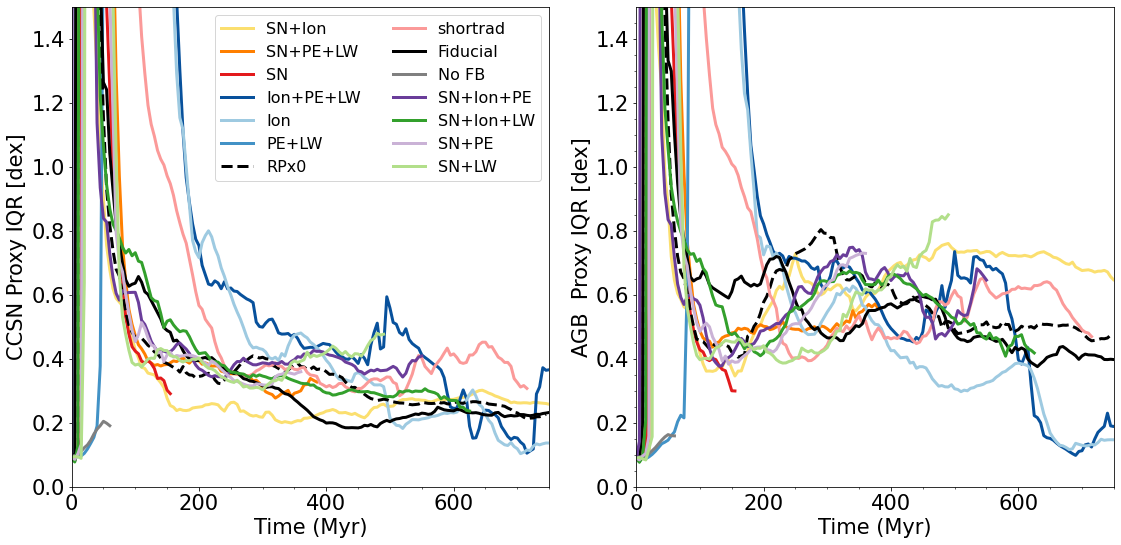

In [63]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,8)

plot_runs = full_base_comparison

for run in plot_runs:
    x,y = _get_plot_values(all_data, 'CNM', run, 'IQR', 'O')
    ax[0].plot(x-x[0], y, color = colors[run], lw = 3, ls = lstyles[run], label = labels[run])
    
    if run == 'otrad_no-ion-sn' or run == 'nofeed':
        print(run, y[x-x[0]>300])
        
plt.minorticks_on()
    
for run in plot_runs:
    x,y = _get_plot_values(all_data, 'CNM', run, 'IQR', 'Ba')
    ax[1].plot(x-x[0], y, color = colors[run], lw = 3, ls = lstyles[run], label = labels[run])
    if run == 'otrad_no-ion-sn' or run == 'nofeed':
        print(run, y[x-x[0]>300])
for a in ax:
    a.set_xlim(0,1000.0)
    a.set_ylim(0,1.5)
    a.set_xlabel(r'Time (Myr)')
    a.xaxis.set_minor_locator(AutoMinorLocator())    
    a.tick_params(axis='x', which='minor', bottom=True)        
    a.tick_params(axis='y', which='minor', bottom=True)
    plt.minorticks_on()
    
    
ax[0].legend(ncol=2,loc='upper right',prop={'size':16})
#ax[0].legend(ncol=2)

ax[0].set_ylabel(r'CCSN Proxy IQR [dex]')
ax[1].set_ylabel(r'AGB  Proxy IQR [dex]')

ax[0].set_xlim(0,750)
ax[1].set_xlim(0,750)
#ax[0].annotate("ISM", xy = (10,1), xycoords = 'data')
#ax.annotate("CNM-only", xy = (10,1), xycoords = 'data')

plt.tight_layout()

fig.savefig("physics_comparison_IQR.png")

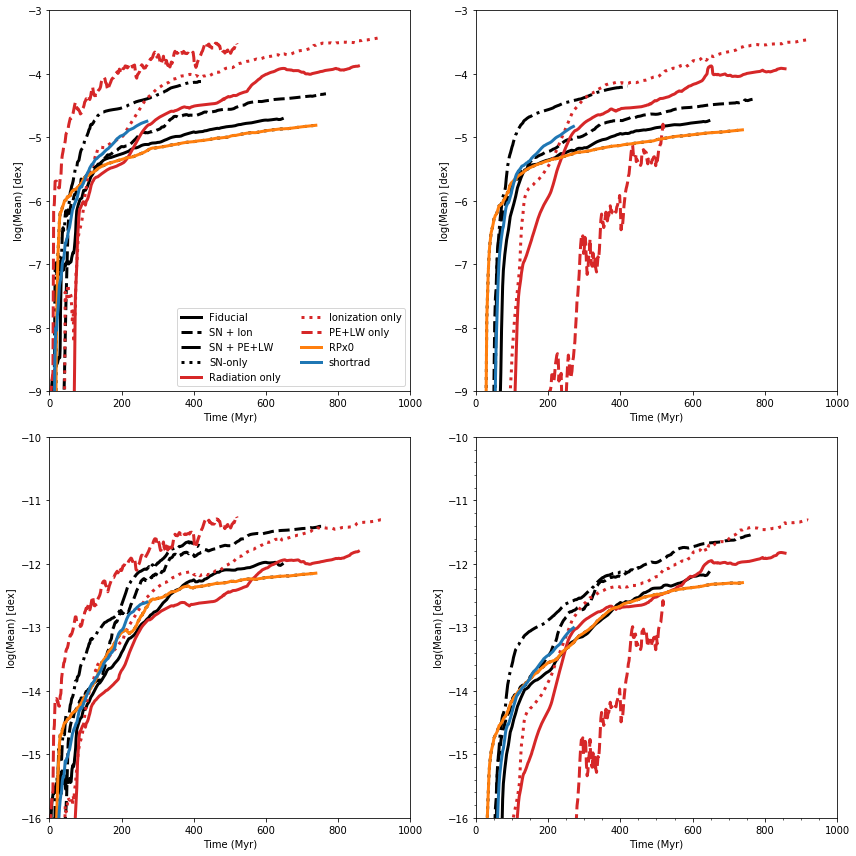

In [23]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(12,12)

plot_runs = base_comparison
    
for run in plot_runs:
    x,y = _get_plot_values(all_data, 'CNM', run, 'mean', 'O')
    ax[(0,0)].plot(x-x[0], y, color = colors[run], lw = 3, ls = lstyles[run], label = labels[run])
    x,y = _get_plot_values(all_data, 'CNM', run, 'median', 'O')
    ax[(0,1)].plot(x-x[0], y, color = colors[run], lw = 3, ls = lstyles[run], label = labels[run])    
for run in plot_runs:
    x,y = _get_plot_values(all_data, 'CNM', run, 'mean', 'Ba')
    ax[(1,0)].plot(x-x[0], y, color = colors[run], lw = 3, ls = lstyles[run], label = labels[run])
    x,y = _get_plot_values(all_data, 'CNM', run, 'median', 'Ba')
    ax[(1,1)].plot(x-x[0], y, color = colors[run], lw = 3, ls = lstyles[run], label = labels[run])
    
for a in ax:    
    for a2 in a:
        a2.set_xlim(0,1000.0)
    #a.set_ylim(0,1.5)
        a2.set_ylabel(r'log(Mean) [dex]')
        a2.set_xlabel(r'Time (Myr)')

for i in np.arange(2):
    ax[(0,i)].set_ylim(-9,-3)
    ax[(1,i)].set_ylim(-16,-10)
ax[(0,0)].legend(ncol=2)
plt.minorticks_on()
plt.tight_layout()

#ax[0].annotate("ISM", xy = (10,1), xycoords = 'data')
#ax.annotate("CNM-only", xy = (10,1), xycoords = 'data')


fig.savefig("physics_comparison_median.png")

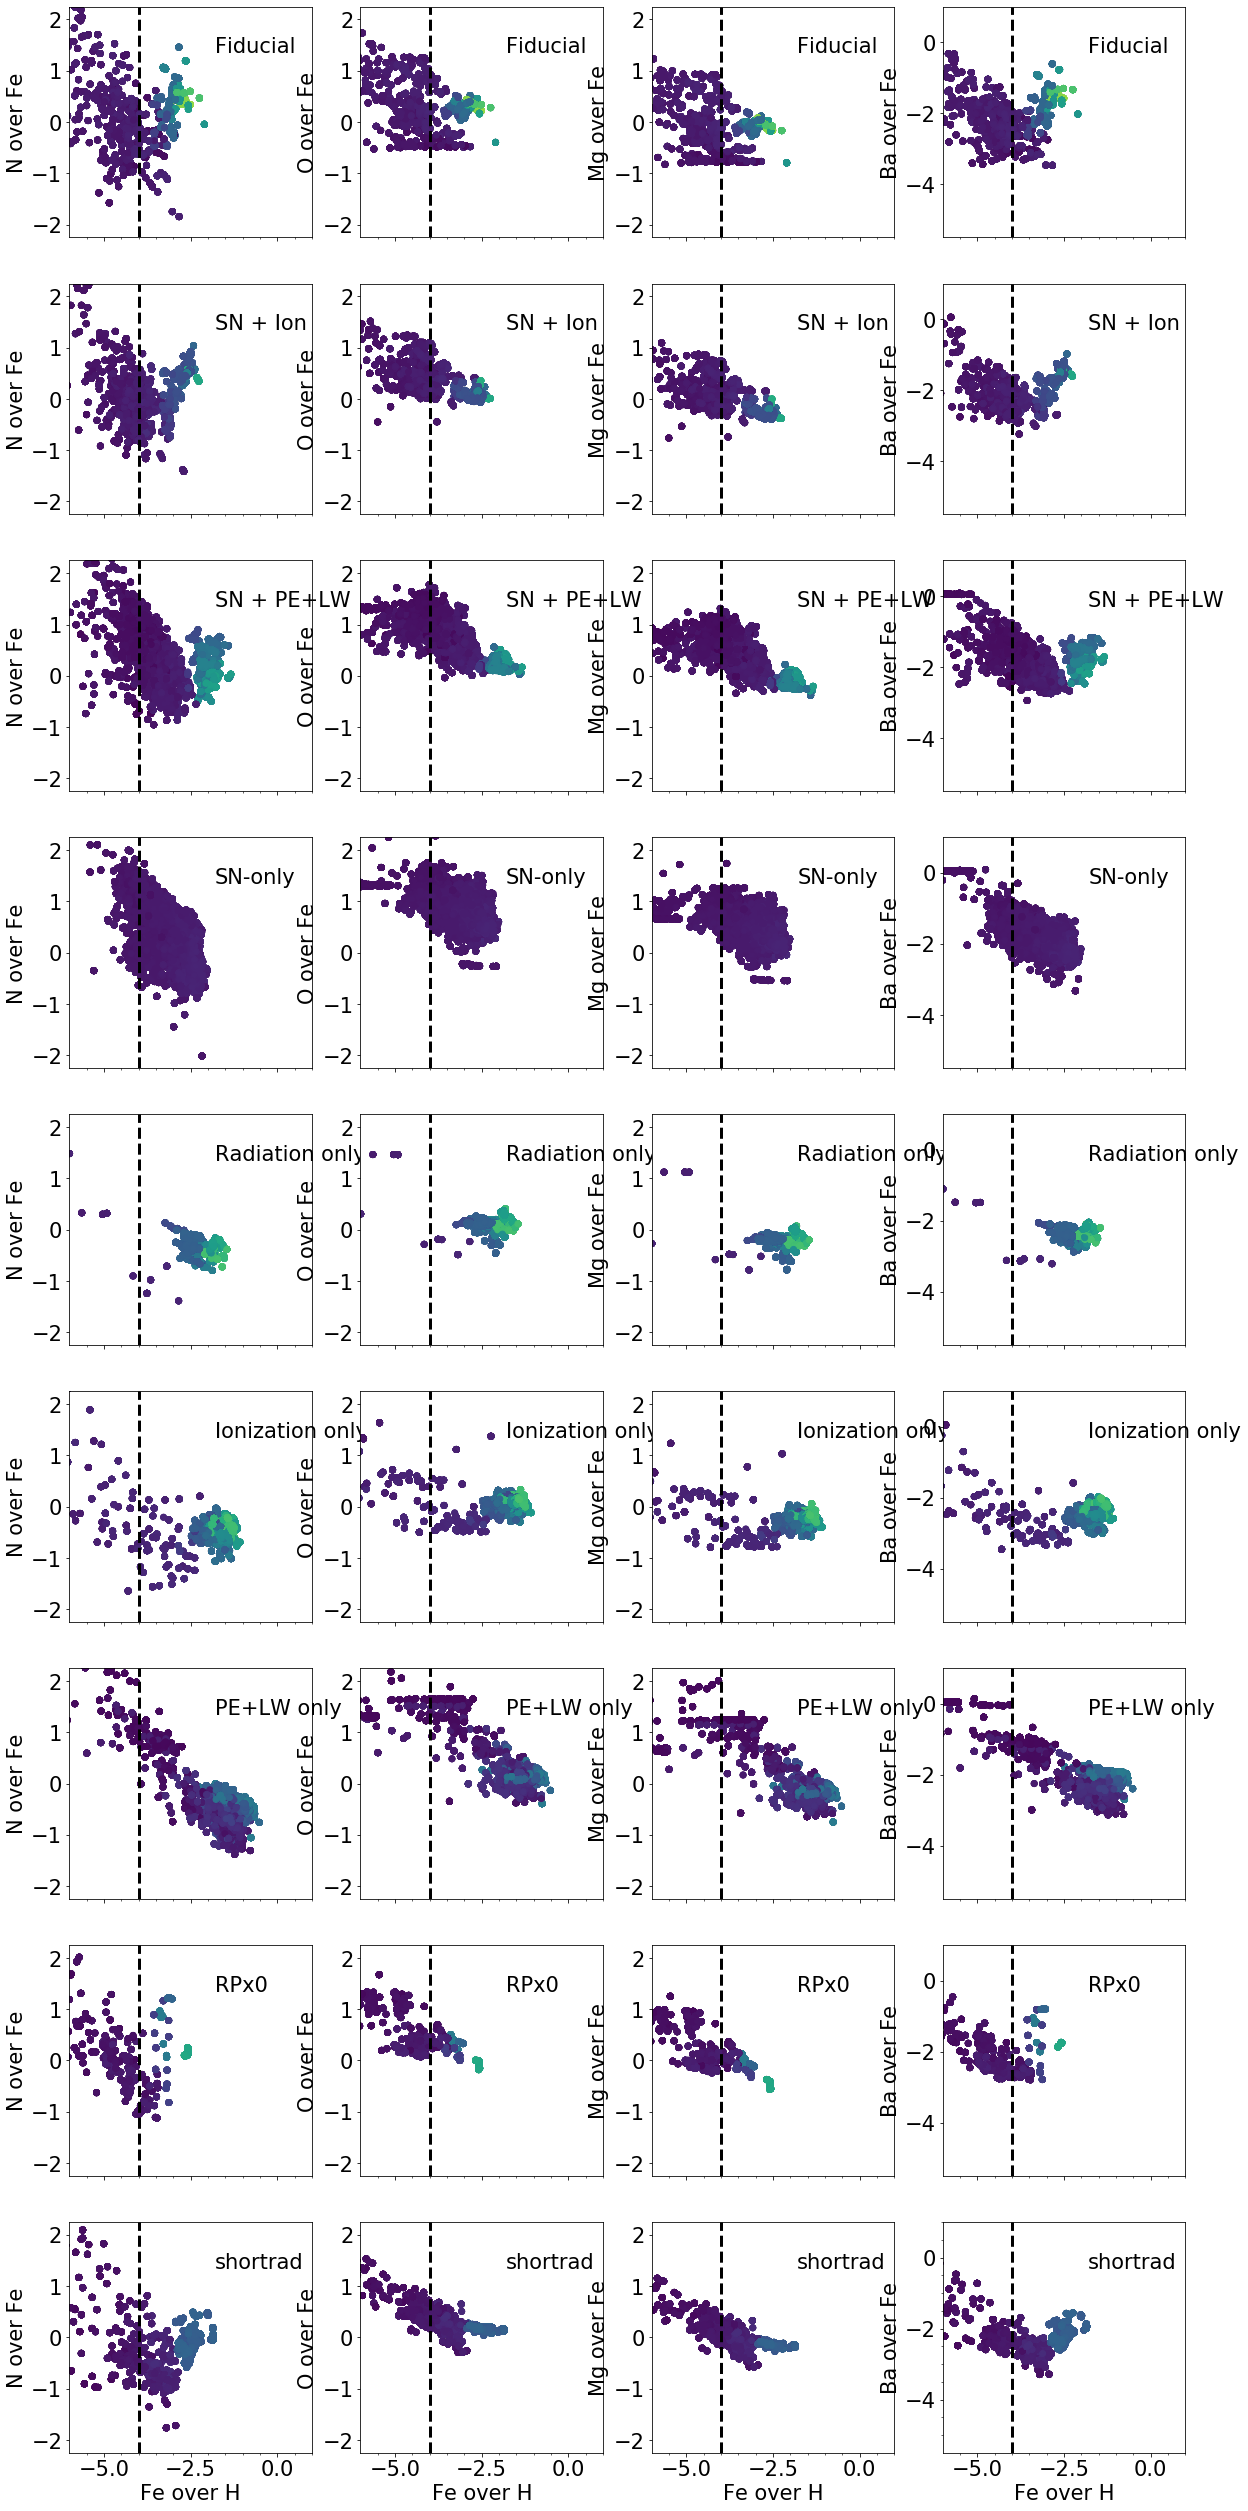

In [161]:
t = 1200.0 * yt.units.Myr

elements = ['N','O','Mg','Ba']

plot_runs = base_comparison

nrow = len(plot_runs)
ncol = 4
fig,ax = plt.subplots(nrow, ncol,sharex=True)
fig.set_size_inches(ncol*5,nrow*5)

axi = 0
axj = 0


denom_element = 'Fe'
#xdata = xdata - np.min(xdata)

e1 = 'Fe'
e2 = 'H'
#xdata = convert_abundances.renormalize(xdata, e1,e2)


for run in plot_runs:
    
    gal = all_galaxies[run]
    
    select = is_alive(gal.df, t)
    
    
    cdata = gal.df['creation_time'].convert_to_units('Myr')
    cdata = (cdata - np.min(cdata)) # / np.max(cdata) *1200 # set same scaling for all ?
    
    
    xdata = gal.df[('io','particle_' + e1 + '_over_' + e2)]

    bins = np.arange(-30,0, 0.1)
    for e in elements:
        index = (axi,axj)
        if e == denom_element:
            continue
        
        ydata = gal.df[('io','particle_' + e + '_over_' + denom_element)]
    #ydata = convert_abundances.renormalize(ydata, e, denom_element)
    
        cax = ax[index].scatter(xdata[select], ydata[select], c = cdata[select])
        cax.set_clim(0.0,1200.0)

    #ax[index].set_xlim(-20,0)
    #ax[index].set_ylim(0,1)
    #ax[index].semilogy()
        ax[index].set_ylabel(e + ' over ' + denom_element)
        ax[index].set_xlim(-6, 1)
        

        #ax[index].set_ylim(np.median(ydata[select]) - 2, np.median(ydata[select]) + 2)
        if e == 'Ba':
            ax[index].set_ylim(-5.5,1)
        else:
            ax[index].set_ylim(-2.25,2.25)
        
        ax[index].plot([-4,-4],ax[index].get_ylim(), lw = 3, ls = '--', color = 'black')
    
        xy = (0.6,0.8)
        ax[index].annotate(labels[run], xy,xy, xycoords='axes fraction')
    
        axj = axj + 1
        if axj >= ncol:
            axj = 0
            axi = axi + 1
            
            
        plt.minorticks_on()
        
for i in np.arange(ncol):
    ax[(nrow-1,i)].set_xlabel(e1 + ' over ' + e2)

    
fig.savefig("physics_comparison_stellar_abundances.png")

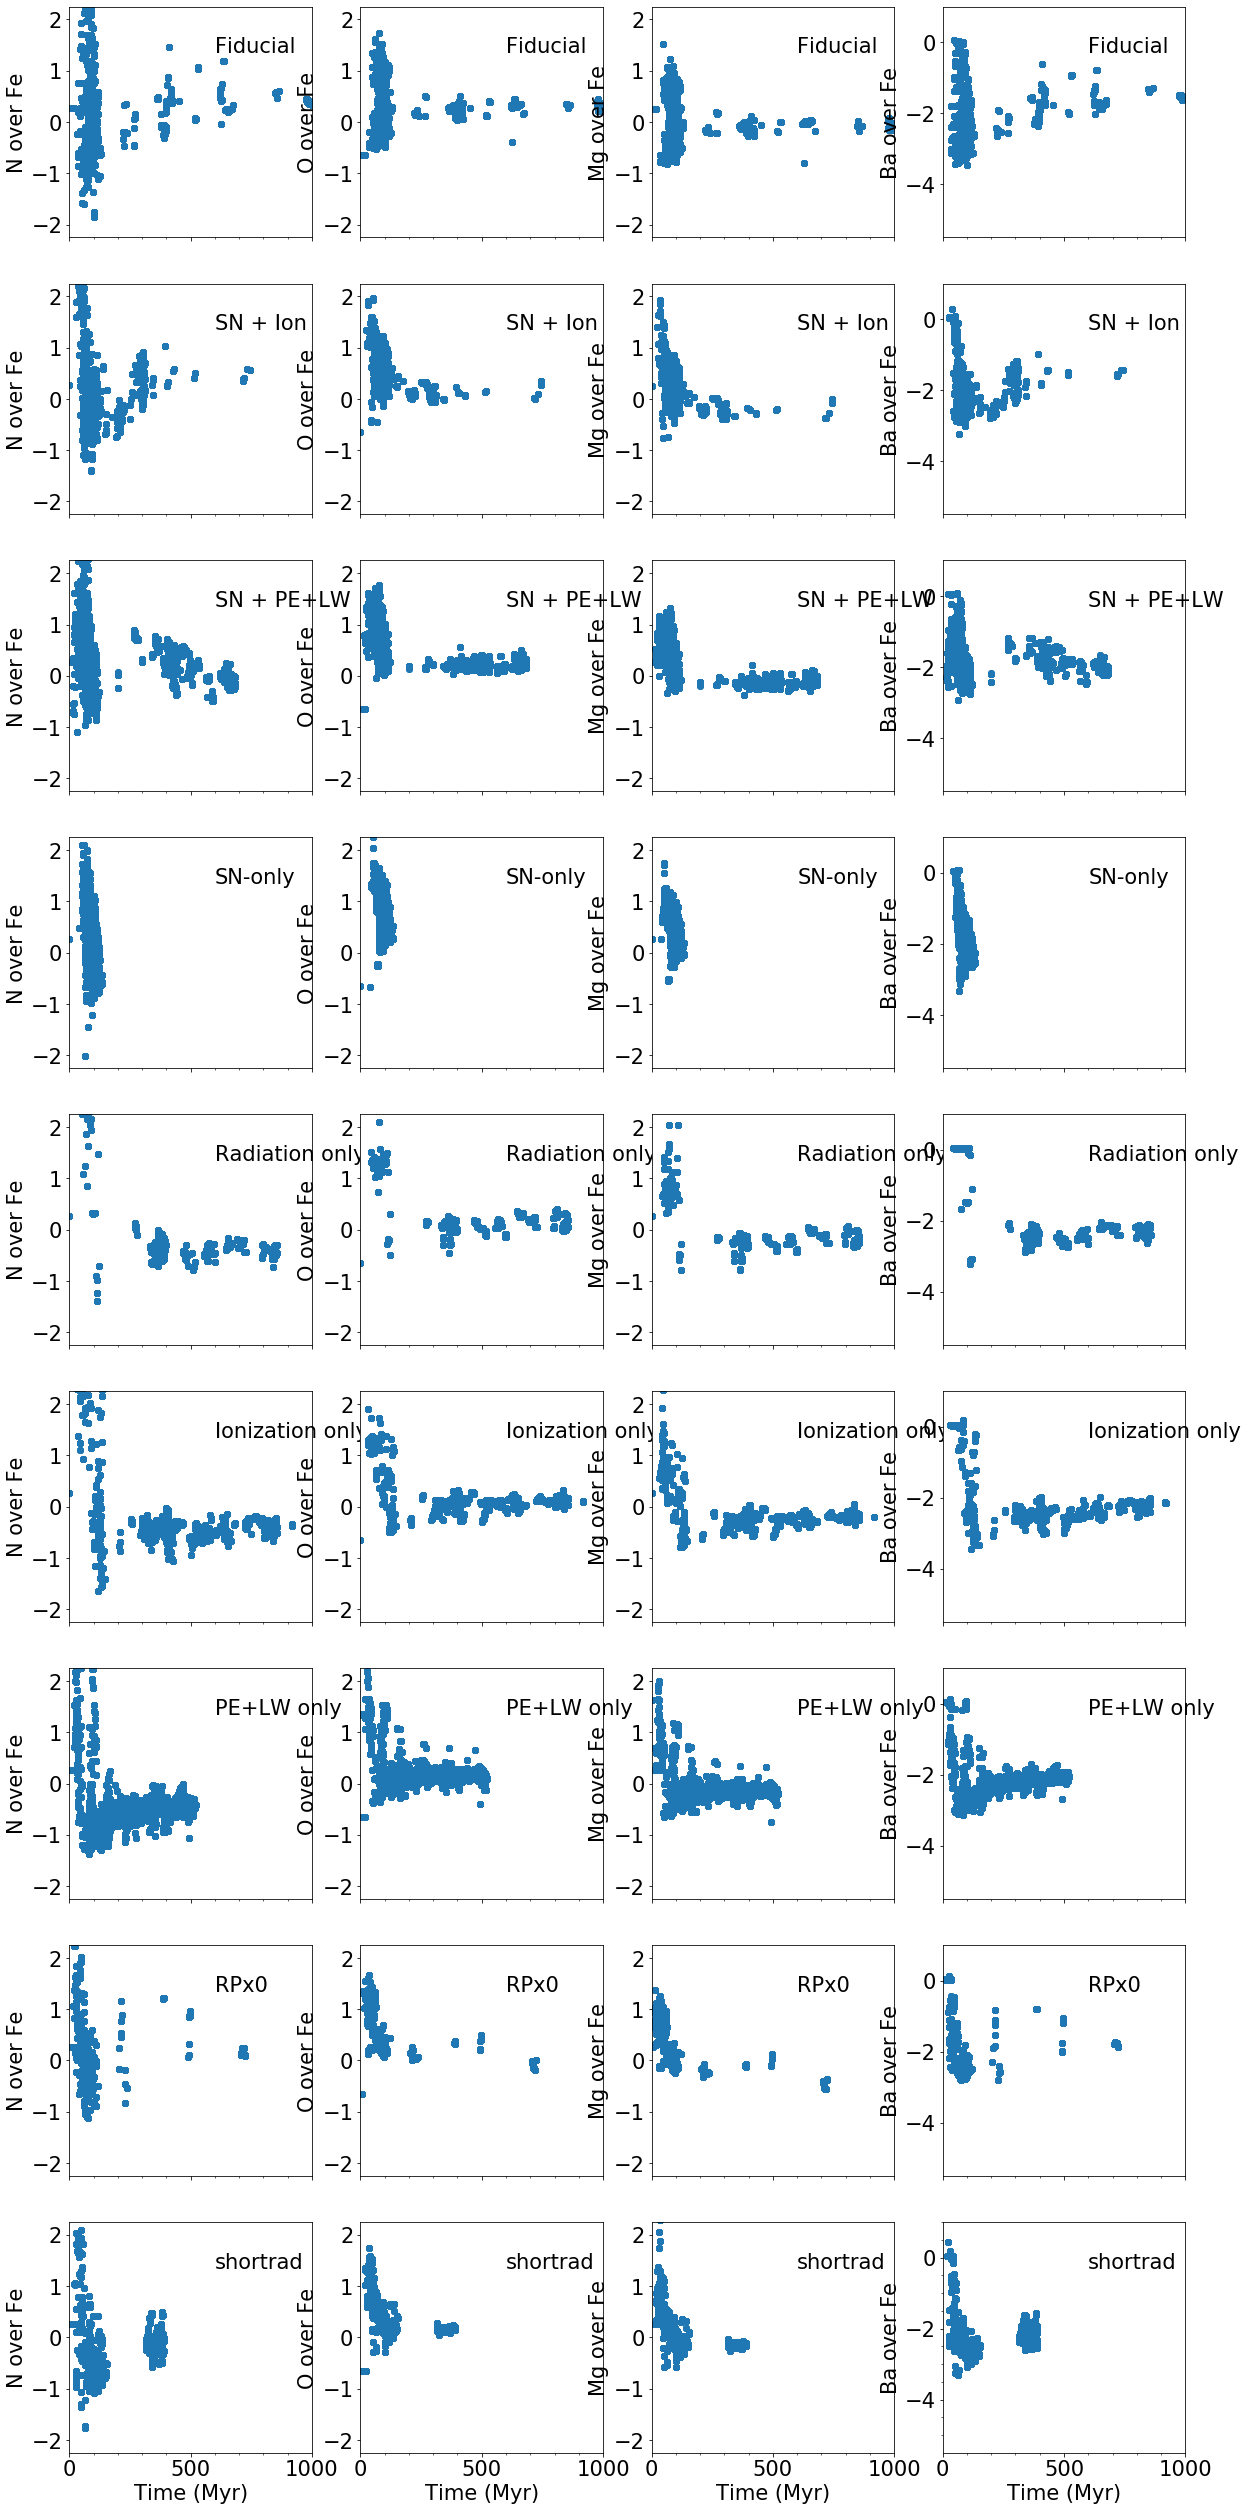

In [160]:
t = 1200.0 * yt.units.Myr

elements = ['N','O','Mg','Ba']

plot_runs = base_comparison

nrow = len(plot_runs)
ncol = 4
fig,ax = plt.subplots(nrow, ncol,sharex=True)
fig.set_size_inches(ncol*5,nrow*5)

axi = 0
axj = 0


denom_element = 'Fe'
#xdata = xdata - np.min(xdata)

e1 = 'Fe'
e2 = 'H'
#xdata = convert_abundances.renormalize(xdata, e1,e2)


for run in plot_runs:
    
    gal = all_galaxies[run]
    
    select = is_alive(gal.df, t)
    
    
    cdata = gal.df['creation_time'].convert_to_units('Myr')
    cdata = (cdata - np.min(cdata)) # / np.max(cdata) *1200 # set same scaling for all ?
    
    
    # xdata = gal.df[('io','particle_' + e1 + '_over_' + e2)]

    bins = np.arange(-30,0, 0.1)
    for e in elements:
        index = (axi,axj)
        if e == denom_element:
            continue
        
        ydata = gal.df[('io','particle_' + e + '_over_' + denom_element)]
    #ydata = convert_abundances.renormalize(ydata, e, denom_element)
    
        ax[index].scatter(cdata[select], ydata[select]) # , c = cdata[select])
        #cax.set_clim(0.0,1200.0)

    #ax[index].set_xlim(-20,0)
    #ax[index].set_ylim(0,1)
    #ax[index].semilogy()
        ax[index].set_ylabel(e + ' over ' + denom_element)
        ax[index].set_xlim(0,1000.0)
        

        #ax[index].set_ylim(np.median(ydata[select]) - 2, np.median(ydata[select]) + 2)
        if e == 'Ba':
            ax[index].set_ylim(-5.5,1)
        else:
            ax[index].set_ylim(-2.25,2.25)
        
        #ax[index].plot([-4,-4],ax[index].get_ylim(), lw = 3, ls = '--', color = 'black')
    
        xy = (0.6,0.8)
        ax[index].annotate(labels[run], xy,xy, xycoords='axes fraction')
    
        axj = axj + 1
        if axj >= ncol:
            axj = 0
            axi = axi + 1
            
            
        plt.minorticks_on()
        
for i in np.arange(ncol):
    ax[(nrow-1,i)].set_xlabel('Time (Myr)')

    
fig.savefig("physics_comparison_stellar_abundances_time.png")

In [13]:
t = 1200.0 * yt.units.Myr

elements = ['N','O','Mg','Ba']

plot_runs = base_comparison

nrow = len(plot_runs)
ncol = 4
fig,ax = plt.subplots(nrow, ncol,sharex=True)
fig.set_size_inches(ncol*5,nrow*5)

axi = 0
axj = 0


denom_element = 'H'
#xdata = xdata - np.min(xdata)

e1 = 'Fe'
e2 = 'H'
#xdata = convert_abundances.renormalize(xdata, e1,e2)


for run in plot_runs:
    
    gal = all_galaxies[run]
    
    select = is_alive(gal.df, t)
    
    
    cdata = gal.df['creation_time'].convert_to_units('Myr')
    cdata = (cdata - np.min(cdata)) # / np.max(cdata) *1200 # set same scaling for all ?
    
    
    # xdata = gal.df[('io','particle_' + e1 + '_over_' + e2)]

    bins = np.arange(-30,0, 0.1)
    for e in elements:
        index = (axi,axj)
        if e == denom_element:
            continue
        
        ydata = gal.df[('io','particle_' + e + '_over_' + denom_element)]
    #ydata = convert_abundances.renormalize(ydata, e, denom_element)
    
        ax[index].scatter(cdata[select], ydata[select]) # , c = cdata[select])
        #cax.set_clim(0.0,1200.0)

    #ax[index].set_xlim(-20,0)
    #ax[index].set_ylim(0,1)
    #ax[index].semilogy()
        ax[index].set_ylabel(e + ' over ' + denom_element)
        ax[index].set_xlim(0,1000.0)
        

        #ax[index].set_ylim(np.median(ydata[select]) - 2, np.median(ydata[select]) + 2)
        ax[index].set_ylim(-10,0)
        
        #ax[index].plot([-4,-4],ax[index].get_ylim(), lw = 3, ls = '--', color = 'black')
    
        xy = (0.6,0.8)
        ax[index].annotate(labels[run], xy,xy, xycoords='axes fraction')
    
        axj = axj + 1
        if axj >= ncol:
            axj = 0
            axi = axi + 1
            
            
        plt.minorticks_on()
        
for i in np.arange(ncol):
    ax[(nrow-1,i)].set_xlabel('Time (Myr)')

    
fig.savefig("physics_comparison_stellar_abundances_time.png")

In [14]:
plot_settings()

t_alive = 1000.0 * yt.units.Myr
r_form = 0.0 * yt.units.Myr

dbin = 0.1

fraction = True
norm     = True

def plot_axis(_ax, runs, e1, e2, rmin, rmax, dbin):
      
    for run in runs:    
        
        hist,bins, init_abund = MDF(all_galaxies[run], e1, e2, 
                                    dbin = dbin, rmin = rmin, rmax = rmax,t_form = t_form,
                                    alive = True, t_alive = t_alive, initial_abund = True)
    
    #print(init_abund)

        if fraction:
            yvals = hist / (1.0*np.sum(hist))
        else:
            yvals = 1.0*hist
        
        if norm:
            yvals = yvals / dbin
        
        if True:
            _ax.step(bins, yvals, where ='post' ,lw = 3, color = colors[run], label = labels[run], ls = lstyles[run])        
        else:
            _ax.plot(bins, yvals, lw = 3, color = colors[run], label = run, ls = lstyles[run])
            
    return


abund_list = [('Mg','H'),  ('Ba','H')]
#abund_list = [('Mg','Fe'), ('Ba','Mg'), ('Ba','Fe')]

fs = 6
nrow = 3
ncol = len(abund_list)

fig, all_axes = plt.subplots(nrow,ncol,sharey=True)
fig.set_size_inches(ncol*fs,nrow*fs)
fig.subplots_adjust(hspace=0,wspace=0)
#
e1 = 'Fe'
e2 = 'H'



for i, epair in enumerate(abund_list):
    e1,e2 = epair
    
    if e2 == 'H':
        if e1 == 'Ba':
            rmin, rmax = -12,-2
        else:
            rmin, rmax = -8, 1
    else:
        rmin, rmax = -5,5
    
    
    runs = ['sn_only','sn_otrad_no-ion','sn_ion-no-otrad','fiducial']
    plot_axis(all_axes[(0,i)], runs, e1, e2, rmin, rmax, dbin)
    runs = ['otrad_ion-no-sn','ion_no-otrad-sn','otrad_no-ion-sn','fiducial']
    plot_axis(all_axes[(2,i)], runs, e1, e2, rmin, rmax, dbin)
    runs = ['shortrad','sn_otrad_ion_noRP','sn_otrad_ion_RPx2','sn_otrad_ion_RPx5','fiducial']
    plot_axis(all_axes[(1,i)], runs, e1, e2, rmin, rmax, dbin)


    count = 0
    for j,ax in enumerate(all_axes[:,i]):
        
        ax.set_xlim(rmin,rmax)
        #ax.semilogy()
        ax.set_xlabel('[' + e1 + '/' + e2 +']')


        count = count + 1
    
        ax.set_ylim(0,5)
        ylim = ax.get_ylim()
        #ax.plot([init_abund,init_abund], ylim, lw = 4, color ='black', ls = '--')
        ax.set_ylim(ylim)
    
for ax in all_axes[:,0]:
    ax.legend(loc='upper left', ncol = 1)
    
    if fraction and not norm:
        ax.set_ylabel(r'dN/N')
    elif fraction and norm:
        ax.set_ylabel(r'dN/Ndlog(Z)')
    elif not fraction and norm:
        ax.set_ylabel(r'dN/dlog(Z)')
    elif not fraction and not norm:
        ax.set_ylabel(r'N')    
    
outstr = ''
for epair in abund_list:
    outstr = outstr + epair[0] + epair[1] + '_'
    
    
outstr = outstr + '_stellar_MDFs.png'
    
fig.savefig(outstr)

NameError: name 't_form' is not defined

In [43]:
plot_settings()

fraction = True
norm     = True
dbin = 0.1

def plot_axis(_ax, runs, e1, e2, rmin, rmax, dbin, t_alive, t_form):
      
    #ut = False
    #f e2 != 'H':
        # arbitrary value to cut on
     #  cut = -20
        
        
    for run in runs:    
        
        hist,bins, init_abund = MDF(all_galaxies[run], e1, e2, 
                                    dbin = dbin, rmin = rmin, rmax = rmax,
                                    alive = True, t_alive = t_alive, t_form = t_form,
     #                              cut_low_Z = cut, 
                                    initial_abund = True)
    
    #print(init_abund)

        if fraction:
            yvals = hist / (1.0*np.sum(hist))
        else:
            yvals = 1.0*hist
        
        if norm:
            yvals = yvals / dbin
        
        if True:
            _ax.step(bins, yvals, where ='post' ,lw = 3, color = colors[run], label = labels[run], ls = lstyles[run])        
        else:
            _ax.plot(bins, yvals, lw = 3, color = colors[run], label = run, ls = lstyles[run])
            
            
        #_ax.plot([init_abund]*2, [0,1], lw = 4, color ='black',ls='--')
            
    return 


abund_list = [('Ca','Mg'), ('Ba','Mg')]
#abund_list = [('Mg','H'), ('Ba','H')]

fs = 6
nrow = 3
ncol = len(abund_list)

fig, all_axes = plt.subplots(nrow,ncol,sharey=True)
fig.set_size_inches(ncol*fs,nrow*fs)
fig.subplots_adjust(hspace=0,wspace=0)
#
#e1 = 'Fe'
#e2 = 'H'

t_alive = 500.0 * yt.units.Myr  # only stars still alive at this point
t_form  = 400.0 # 250.0 * yt.units.Myr    # only stars formed after this




for i, epair in enumerate(abund_list):
    e1,e2 = epair
    print(e1,e2)
    
    if e2 == 'H':
        if e1 == 'Ba':
            rmin, rmax = -12,-2
        else:
            rmin, rmax = -8, 1
    else:
        rmin, rmax = -5,3
    
    
#    runs = ['sn_only','sn_otrad_no-ion','sn_ion-no-otrad','snpe_noion','snlw_noion','fiducial']
#    plot_axis(all_axes[(0,i)], runs, e1, e2, rmin, rmax, dbin, t_alive, t_form)
#    runs = ['snpe','snlw','otrad_ion-no-sn','ion_no-otrad-sn','otrad_no-ion-sn','fiducial']
#    plot_axis(all_axes[(2,i)], runs, e1, e2, rmin, rmax, dbin, t_alive, t_form)
#    runs = ['shortrad','sn_otrad_ion_noRP','sn_otrad_ion_RPx10','fiducial']
#    plot_axis(all_axes[(1,i)], runs, e1, e2, rmin, rmax, dbin, t_alive, t_form)

    runs = ['sn_only','sn_otrad_no-ion','sn_ion-no-otrad','fiducial']
    #runs = ['fiducial']    
    runs = ['sn_only','sn_ion-no-otrad','snpe','snlw','fiducial']
    
    plot_axis(all_axes[(0,i)], runs, e1, e2, rmin, rmax, dbin,t_alive,t_form)
    runs = ['fiducial']
    #runs = ['otrad_ion-no-sn','ion_no-otrad-sn','otrad_no-ion-sn','fiducial']
    runs = ['otrad_ion-no-sn','ion_no-otrad-sn','otrad_no-ion-sn','fiducial']
    
    plot_axis(all_axes[(2,i)], runs, e1, e2, rmin, rmax, dbin,t_alive,t_form)
    runs = ['fiducial']
    
    runs = ['shortrad','sn_otrad_ion_noRP','sn_otrad_ion_RPx2','sn_otrad_ion_RPx5','fiducial']
    
    runs = ['shortrad','snpe_noion','snlw_noion','sn_otrad_no-ion','fiducial']
    
    plot_axis(all_axes[(1,i)], runs, e1, e2, rmin, rmax, dbin,t_alive,t_form)
    

    count = 0
    for j,ax in enumerate(all_axes[:,i]):
        
        if e2 == 'H':
            if j ==0 or j == 1:
                ax.set_xlim(-4,0)
            else:
                ax.set_xlim(-4,0)
        else:
            if i == 0:
                ax.set_xlim(-1.75,1.75)
            elif i == 1:
                ax.set_xlim(-3.25,0.25)
            else:
                ax.set_xlim(-3.25,0.25)    
                
        #ax.set_xlim(rmin,rmax)
        #ax.semilogy()
        if j == 2:
            ax.set_xlabel('[' + e1 + '/' + e2 +']')


        count = count + 1
    
        ax.set_ylim(0,4)
        #ax.semilogy()
#        ylim = ax.get_ylim()
#        ax.plot([init_abund,init_abund], ylim, lw = 4, color ='black', ls = '--')
#        ax.set_ylim(ylim)
    
for ax in all_axes[:,0]:
    if fraction and not norm:
        ax.set_ylabel(r'dN/N')
    elif fraction and norm:
        ax.set_ylabel(r'dN/Ndlog(Z)')
    elif not fraction and norm:
        ax.set_ylabel(r'dN/dlog(Z)')
    elif not fraction and not norm:
        ax.set_ylabel(r'N')    
        
for ax in all_axes[:,1]:
    ax.legend(loc='upper left', ncol=2,prop={'size':16})

outstr = ''
for epair in abund_list:
    outstr = outstr + epair[0] + epair[1] + '_'
    
outstr = outstr + '_stellar_MDFs.png'
    
fig.savefig(outstr)

<ipython-input-43-3b421bef719f>:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, all_axes = plt.subplots(nrow,ncol,sharey=True)


Ca Mg
Ba Mg


In [105]:
print(colors['sn_ion_no-otrad'])

#fd8d3c


In [42]:
plot_settings()
def plot_axis(_ax, runs, e1, e2, rmin, rmax, dbin,t_alive,tform):
      
    for run in runs:    
        
        hist,bins, init_abund = MDF(all_galaxies[run], e1, e2, 
                                    dbin = dbin, rmin = rmin, rmax = rmax,t_form=t_form,
                                    alive = True, t_alive = t_alive, initial_abund = True)
    
    #print(init_abund)

        if fraction:
            yvals = hist / (1.0*np.sum(hist))
        else:
            yvals = 1.0*hist
        
        if norm:
            yvals = yvals / dbin
        
        if True:
            _ax.step(bins, yvals, where ='post' ,lw = 3, color = colors[run], label = labels[run], ls = lstyles[run])        
        else:
            _ax.plot(bins, yvals, lw = 3, color = colors[run], label = run, ls = lstyles[run])
            
    return


abund_list = [('Mg','H'), ('Ba','H')]
#abund_list = [('Ca','Mg'), ('Ba','H')]

fs = 6
nrow = 3
ncol = len(abund_list)

fig, all_axes = plt.subplots(nrow,ncol,sharey=True)
fig.set_size_inches(ncol*fs,nrow*fs)
fig.subplots_adjust(hspace=0,wspace=0)
#
e1 = 'Fe'
e2 = 'H'

t_alive = 500.0 * yt.units.Myr
#t_form  = 300.0 * yt.units.Myr

dbin = 0.2

fraction = True
norm     = True



for i, epair in enumerate(abund_list):
    e1,e2 = epair
    
    if e2 == 'H':
        if e1 == 'Ba':
            rmin, rmax = -12,-2
        else:
            rmin, rmax = -8, 1
    else:
        rmin, rmax = -5,5
    
    
    runs = ['sn_only','sn_otrad_no-ion','sn_ion-no-otrad','fiducial']
    #runs = ['fiducial']    
    runs = ['sn_only','sn_ion-no-otrad','snpe','snlw','fiducial']
    
    plot_axis(all_axes[(0,i)], runs, e1, e2, rmin, rmax, dbin,t_alive,t_form)
    runs = ['fiducial']
    #runs = ['otrad_ion-no-sn','ion_no-otrad-sn','otrad_no-ion-sn','fiducial']
    runs = ['otrad_ion-no-sn','ion_no-otrad-sn','otrad_no-ion-sn','fiducial']
    
    plot_axis(all_axes[(2,i)], runs, e1, e2, rmin, rmax, dbin,t_alive,t_form)
    runs = ['fiducial']
    
    runs = ['shortrad','sn_otrad_ion_noRP','sn_otrad_ion_RPx2','sn_otrad_ion_RPx5','fiducial']
    
    runs = ['shortrad','snpe_noion','snlw_noion','sn_otrad_no-ion','fiducial']
    
    plot_axis(all_axes[(1,i)], runs, e1, e2, rmin, rmax, dbin,t_alive,t_form)


    count = 0
    for j,ax in enumerate(all_axes[:,i]):
        
        ax.set_xlim(rmin,rmax)
        #ax.semilogy()
        ax.set_xlabel('[' + e1 + '/' + e2 +']')


        count = count + 1
    
        ax.set_ylim(0,1)
        ylim = ax.get_ylim()
       # ax.plot([init_abund,init_abund], ylim, lw = 4, color ='black', ls = '--')
        ax.set_ylim(ylim)
    
for ax in all_axes[:,0]:
    ax.legend(loc='upper left', ncol = 1, prop={'size':16})
    
    if fraction and not norm:
        ax.set_ylabel(r'dN/N')
    elif fraction and norm:
        ax.set_ylabel(r'dN/Ndlog(Z)')
    elif not fraction and norm:
        ax.set_ylabel(r'dN/dlog(Z)')
    elif not fraction and not norm:
        ax.set_ylabel(r'N')    
    
outstr = ''
for epair in abund_list:
    outstr = outstr + epair[0] + epair[1] + '_'
outstr = outstr + 'stellar_MDFs.png'
    
    
#outstr = 'fiducial_snx2_only_stellar_MDFs.png'
    
fig.savefig(outstr)
plt.close()

<ipython-input-42-7a2e570ef5d5>:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, all_axes = plt.subplots(nrow,ncol,sharey=True)


In [26]:
t = 500.0 * yt.units.Myr

ye1 = 'Ba'
ye2 = 'Fe'

plot_runs =  ['fiducial', 'sn_otrad_no-ion', 'sn_ion-no-otrad',
        'shortrad', 'sn_only', 'sn_otrad_ion_noRP',
        'otrad_ion-no-sn', 'otrad_no-ion-sn', 'ion_no-otrad-sn']

nrow = 3
ncol = 3
fs = 5
fig, ax = plt.subplots(3,3, sharex=True, sharey=True)
fig.set_size_inches(fs*3,fs*3)
fig.subplots_adjust(wspace=0,hspace=0)

axi = 0
axj = 0


#xdata = xdata - np.min(xdata)

e1 = 'Fe'
e2 = 'H'
#xdata = convert_abundances.renormalize(xdata, e1,e2)


for run in plot_runs:
    index = (axi,axj)
    
    gal = all_galaxies[run]
    
    select = is_alive(gal.df, t)
    
    cdata = gal.df['creation_time'].convert_to_units('Myr')
    cdata = (cdata - np.min(cdata)) # / np.max(cdata) *1200 # set same scaling for all ?
    
    
    xdata = gal.df[('io','particle_' + e1 + '_over_' + e2)]

    bins = np.arange(-30,0, 0.1)
        
       
    ydata = gal.df[('io','particle_' + ye1 + '_over_' + ye2)]
    #ydata = convert_abundances.renormalize(ydata, e, denom_element)
    
    cax = ax[index].scatter(xdata[select], ydata[select], c = cdata[select], alpha=0.5, s = 20)
    cax.set_clim(0.0,t.value)

    #ax[index].set_xlim(-20,0)
    #ax[index].set_ylim(0,1)
    #ax[index].semilogy()
    if index[1] == 0:
        ax[index].set_ylabel(ye1 + ' over ' + ye2)
    ax[index].set_xlim(-6, 1)
        

        #ax[index].set_ylim(np.median(ydata[select]) - 2, np.median(ydata[select]) + 2)
    if ye1 == 'Ba' and ye2 != 'H':
        ax[index].set_ylim(-5.5,1)
    elif ye2 == 'H':
        ax[index].set_ylim( ax[index].get_xlim())
    else:
        ax[index].set_ylim(-2.25,2.25)
    ax[index].plot([-4,-4],ax[index].get_ylim(), lw = 3, ls = '--', color = 'black')
    
    xy = (0.025,0.025)
    ax[index].annotate(labels[run], xy,xy, xycoords='axes fraction')
    
    axj = axj + 1
    if axj >= ncol:
        axj = 0
        axi = axi + 1
            
            
    plt.minorticks_on()
        
for i in np.arange(ncol):
    ax[(nrow-1,i)].set_xlabel(e1 + ' over ' + e2)

    
fig.savefig("physics_comparison_abundance_panel.png")